# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Importamos los datos

In [4]:
path = 'D:\Documentos de trabajo\Maestría\Tesis Maestría\Trabajo Python Tesis\Github Tesis\Base de datos\Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 100, 100)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(2000, 2, 100, 100)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(1000, 2, 100, 100)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 100, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 7
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creamos función de costo

In [20]:
@tf.function
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 100,100))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 100,100))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-8)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-8)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos = 20
    y1 = tf.linspace(x_range_neg, x_range_pos, 100)
    y2 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y1, Y2 = tf.meshgrid(y1, y2)
    t = 0
    u, v = tf.zeros(Y1.shape), tf.zeros(Y2.shape)
    u, v = f(t, [Y1, Y2])

    #M = tf.sqrt(tf.square(u) + tf.square(v))
    #u /= M
    #v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))
    
    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 100,100))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 100,100))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 100)
    y22 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])
    #M2 = tf.sqrt(tf.square(u2) + tf.square(v2))
    #u2 /= M2
    #v2 /= M2
    print(u)
    print(u2)
    campvecx = tf.subtract(u,u2)
    campvecy = v - v2

    
    campvectotal = campvecx
    
    
    loss = tf.reduce_mean(campvectotal)
    return loss

# Funcion de costo prueba

# Creación del modelo

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,100,100)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7)
])


In [22]:

model = Sequential()
model.add(Flatten(input_shape=(2,100,100)))
model.add(Dense(128,activation='tanh',kernel_initializer=HeNormal()))
model.add(Dropout(0.3))
model.add(Dense(64,activation = 'tanh',kernel_initializer=HeNormal()))
model.add(Dense(128,activation = 'tanh',kernel_initializer=HeNormal()))
model.add(Dense(64,activation = 'tanh',kernel_initializer=HeNormal()))
model.add(Dropout(0.3))
model.add(Dense(128,activation = 'tanh',kernel_initializer=HeNormal()))
model.add(Dense(64,activation = 'tanh',kernel_initializer=HeNormal()))

model.add(Dense(7))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               2560128   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [24]:
keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Entrenamos el modelo

In [25]:
model.compile(optimizer='Adam',
              loss= 'MSE',
              metrics=['mae'])
#model.compile(optimizer='Adam',
 #             loss= 'mse',
  #            metrics=[custom_loss])

In [26]:
def scheduler(epoch, lr):
  if epoch < 500:
    return lr
  else:
    return 1e-3 * 0.99 ** epoch

In [28]:
val_epochs = 100
tf.compat.v1.global_variables_initializer()

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 800,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/100
1000/1000 [==============================] - 5s 5ms/step - loss: 7.3060 - mae: 2.2379 - val_loss: 7.1325 - val_mae: 2.1918 - lr: 0.0010
Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: 7.2684 - mae: 2.2278 - val_loss: 7.1999 - val_mae: 2.2048 - lr: 0.0010
Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: 7.2628 - mae: 2.2227 - val_loss: 7.1357 - val_mae: 2.1909 - lr: 0.0010
Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: 7.1815 - mae: 2.2096 - val_loss: 7.1023 - val_mae: 2.1895 - lr: 0.0010
Epoch 5/100
1000/1000 [==============================] - 5s 5ms/step - loss: 7.1809 - mae: 2.2077 - val_loss: 7.1135 - val_mae: 2.1895 - lr: 0.0010
Epoch 6/100
1000/1000 [==============================] - 5s 5ms/step - loss: 7.1855 - mae: 2.2087 - val_loss: 7.0816 - val_mae: 2.1839 - lr: 0.0010
Epoch 7/100
1000/1000 [==============================] - 5s 5ms/step - loss: 7.2359 - mae: 2.2148 - val_loss: 7.

1000/1000 [==============================] - 4s 4ms/step - loss: 6.9609 - mae: 2.1518 - val_loss: 6.8753 - val_mae: 2.1329 - lr: 0.0010
Epoch 57/100
1000/1000 [==============================] - 5s 5ms/step - loss: 6.9697 - mae: 2.1538 - val_loss: 6.8693 - val_mae: 2.1305 - lr: 0.0010
Epoch 58/100
1000/1000 [==============================] - 4s 4ms/step - loss: 6.9680 - mae: 2.1527 - val_loss: 6.8584 - val_mae: 2.1307 - lr: 0.0010
Epoch 59/100
1000/1000 [==============================] - 5s 5ms/step - loss: 6.9733 - mae: 2.1537 - val_loss: 6.8665 - val_mae: 2.1308 - lr: 0.0010
Epoch 60/100
1000/1000 [==============================] - 4s 4ms/step - loss: 6.9827 - mae: 2.1544 - val_loss: 6.8902 - val_mae: 2.1314 - lr: 0.0010
Epoch 61/100
1000/1000 [==============================] - 5s 5ms/step - loss: 6.9989 - mae: 2.1595 - val_loss: 6.8589 - val_mae: 2.1292 - lr: 0.0010
Epoch 62/100
1000/1000 [==============================] - 5s 5ms/step - loss: 6.9753 - mae: 2.1556 - val_loss: 6.9056 -

# Analizamos accuracy y loss

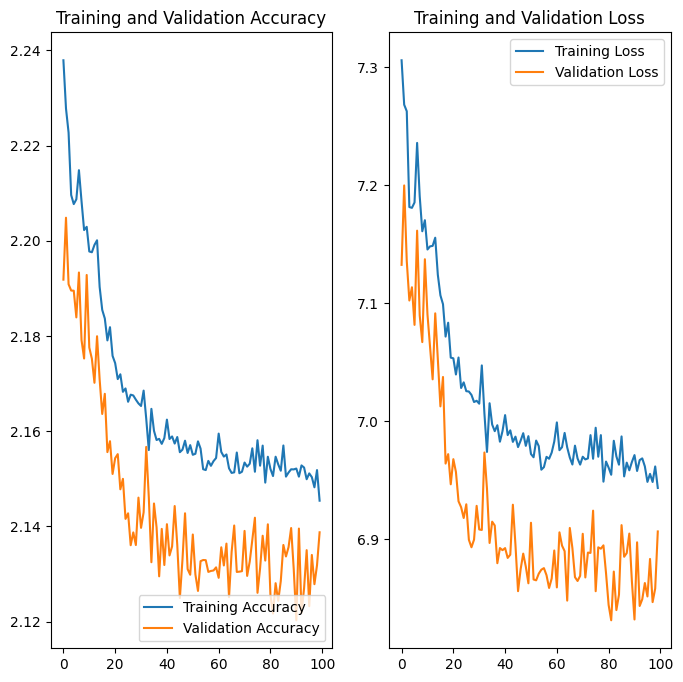

In [29]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Guardamos los datos de Accuracy y Loss

In [30]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../Gráficas finales/historycampvec100.csv', index=False)

# Guardamos el modelo

In [31]:
path_to_save = 'D:/Documentos de trabajo/Maestría/Tesis Maestría/Trabajo Python Tesis/Github Tesis/Modelos/Modelos 100,200'

In [32]:
model.save(path_to_save + '/campovectorial100.h5')

# Importamos el modelo

In [33]:
new_model = keras.models.load_model('../../Modelos/Modelos 100,200/campovectorial100.h5')

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [34]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos =20

    y1 = np.linspace(x_range_neg, x_range_pos, 100)
    y2 = np.linspace(y_range_neg, y_range_pos, 100)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)
    contador = contador+1
    print(contador)
    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[0, 0, 0, 10, 4, 2, 1]
1


C:\Users\rafae\AppData\Local\Temp\ipykernel_2828\641464097.py:53: RuntimeWarning: invalid value encountered in divide
  u /= M
C:\Users\rafae\AppData\Local\Temp\ipykernel_2828\641464097.py:54: RuntimeWarning: invalid value encountered in divide
  v /= M


In [35]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [36]:
new_predictions = new_model.predict(campvecnone)
print(new_predictions)

1/1 [==============================] - 0s 58ms/step
[[5.418769  4.9908285 5.3126507 4.8952665 7.0716057 3.4318113 2.7290916]]


## Graficamos con los coeficientes reales

C:\Users\rafae\AppData\Local\Temp\ipykernel_2828\2773931396.py:9: RuntimeWarning: invalid value encountered in divide
  u /= M
C:\Users\rafae\AppData\Local\Temp\ipykernel_2828\2773931396.py:10: RuntimeWarning: invalid value encountered in divide
  v /= M


Text(0, 0.5, 'Concentración Y')

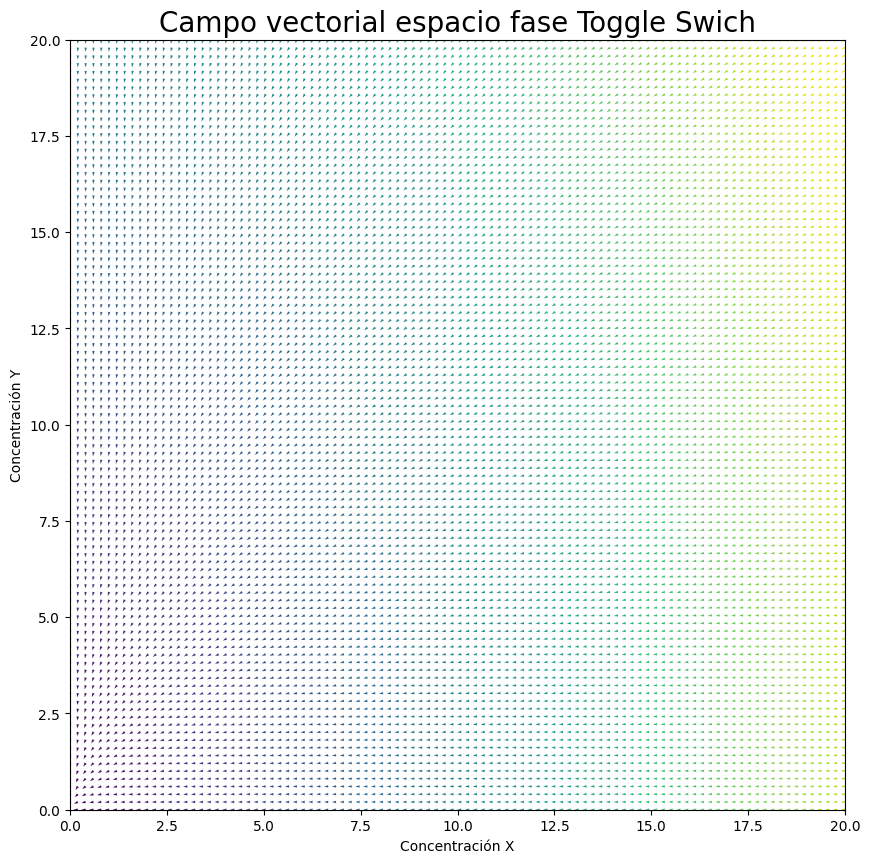

In [37]:
y1 = np.linspace(0, 20, 100)
y2 = np.linspace(0, 20, 100)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

In [38]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

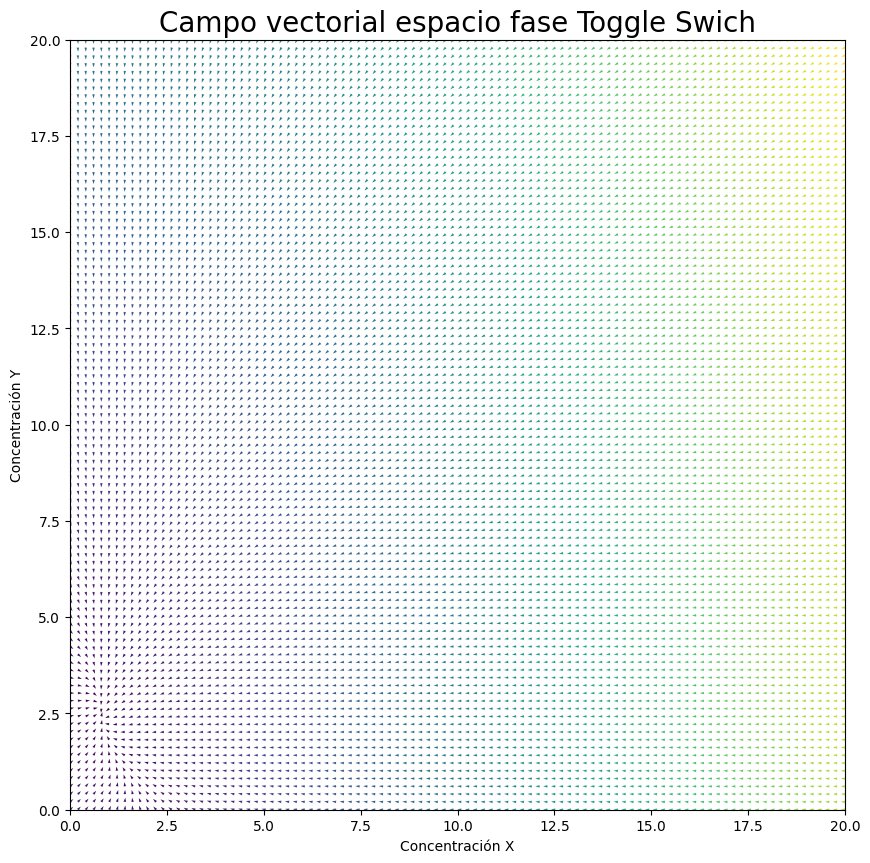

In [39]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]
 
def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 20
y_range_neg = 0
y_range_pos = 20

y1 = np.linspace(x_range_neg, x_range_pos, 100)
y2 = np.linspace(y_range_neg, y_range_pos, 100)

Y1, Y2 = np.meshgrid(y1, y2)
    
t1 = 0

u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

NI, NJ = Y1.shape

u1, v1 = f(t1, [Y1, Y2])
u, v = f(t1, [Y1, Y2])
M = (np.hypot(u, v))
u /= M
v /= M
    
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

# Pruebas mensas

In [40]:
#y_true2 = [[1,2,3,4,5,1,2], [6,7,8,1,2,3,4], [1,2,3,4,5,8,2]]
#y_pred2 = [[2,5,4,3,7,2,1], [1,2,3,7,8,0,1], [2,5,4,3,7,2,5]]
y_true2 = [1,2,3,4,5,1,2]
y_pred2 = [5,5,4,3,9,4,5]

In [70]:
def custom_loss2(y_true2, y_pred2):
    campvec = []
    # constantes
    a1 = y_true2[0]

    a2 =y_true2[1]
    
    b1 = y_true2[2]
    
    b2 = y_true2[3]

    d1 = y_true2[4]

    d2 = y_true2[5]

    n = y_true2[5]
    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 5
    y_range_neg = 0
    y_range_pos =5

    y1 = np.linspace(x_range_neg, x_range_pos, 100)
    y2 = np.linspace(y_range_neg, y_range_pos, 100)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = y_pred2[0]

    a22 =y_pred2[1]
    
    b12 = y_pred2[2]
    
    b22 = y_pred2[3]

    d12 = y_pred2[4]

    d22 = y_pred2[5]

    n2 = y_pred2[5]
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        Y2 = ye2[1]

        # definimos cada ODE
        dX2_dt = a12/(1+Y2**n2)-d12*X2+b12
        dY2_dt = a22/(1+X2**n2)-d22*Y2+b12
        return [dX2_dt, dY2_dt]

    y12 = np.linspace(x_range_neg, x_range_pos, 100)
    y22 = np.linspace(y_range_neg, y_range_pos, 100)
    Y12, Y22 = np.meshgrid(y12, y22)
    u2, v2 = np.zeros(Y12.shape), np.zeros(Y22.shape)
    u2, v2 = f2(t1, [Y12, Y22])
    M2 = np.sqrt(np.square(u2) + np.square(v2))
    u2 /= M2
    v2 /= M2
    campvecx = u- u2
    campvecy = v - v2    
    
    
    #loss = tf.reduce_mean(campvectotal)
    return u,v, u2,v2, campvecx, campvecy,Y1,Y2,Y12,Y22,M,M2

In [71]:
u,v,u2,v2,campvecx,campvecy,Y1,Y2,Y12,Y22,M,M2 = custom_loss2(y_true2,y_pred2)
print(u)

[[ 0.62469505  0.60719189  0.58729543 ... -0.98698699 -0.98731734
  -0.98763553]
 [ 0.62395608  0.60621056  0.58602174 ... -0.98742824 -0.98774723
  -0.98805448]
 [ 0.62363052  0.60566871  0.58521532 ... -0.98785519 -0.98816326
  -0.98846   ]
 ...
 [ 0.99949256  0.99999861  0.99952127 ... -0.99733525 -0.99738744
  -0.99743808]
 [ 0.99987295  0.99987745  0.99875552 ... -0.99716104 -0.99721694
  -0.99727118]
 [ 1.          0.99945609  0.99763222 ... -0.9969814  -0.99704113
  -0.99709909]]


Text(0, 0.5, 'Concentración Y')

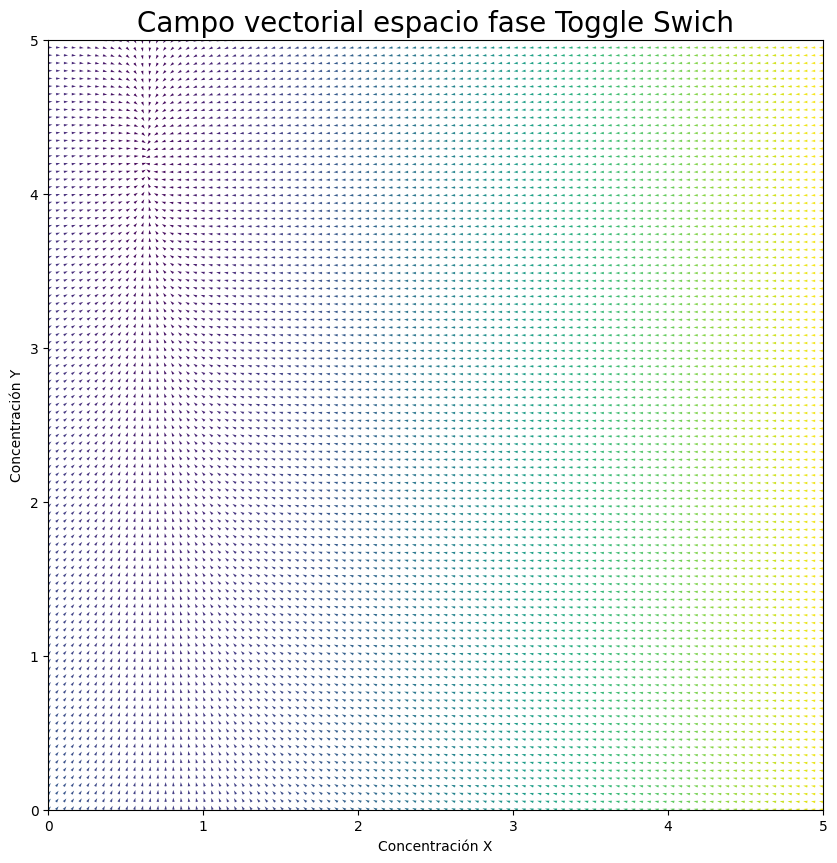

In [72]:
x_range_neg = 0
x_range_pos = 5
y_range_neg = 0
y_range_pos =5
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

Text(0, 0.5, 'Concentración Y')

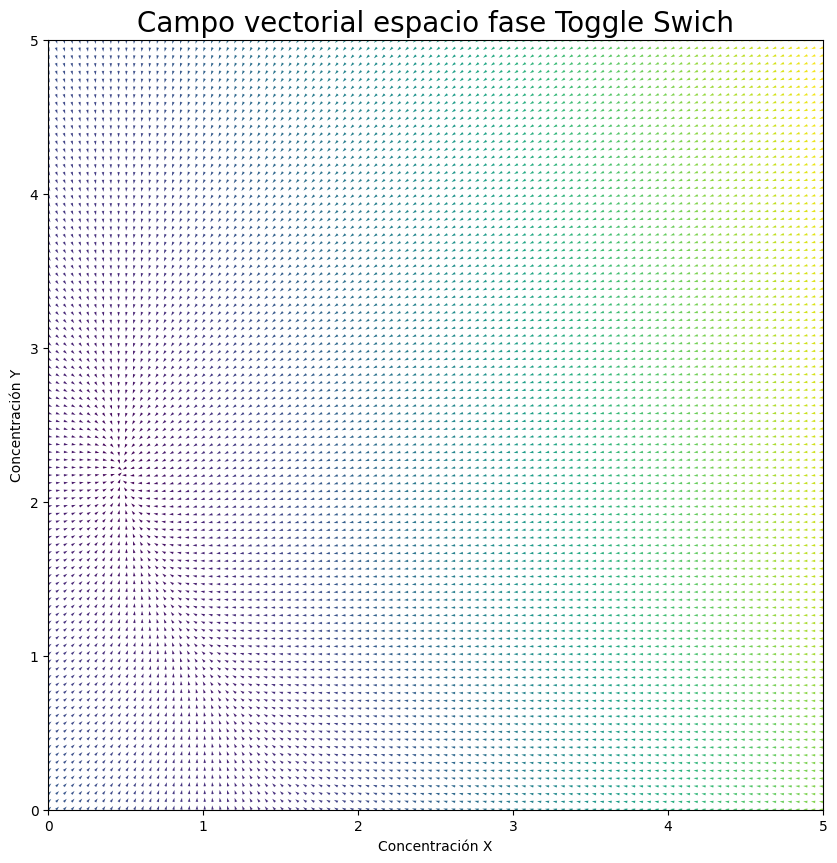

In [73]:
x_range_neg = 0
x_range_pos = 5
y_range_neg = 0
y_range_pos =5
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y12, Y22, u2, v2, M2, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

Text(0, 0.5, 'Concentración Y')

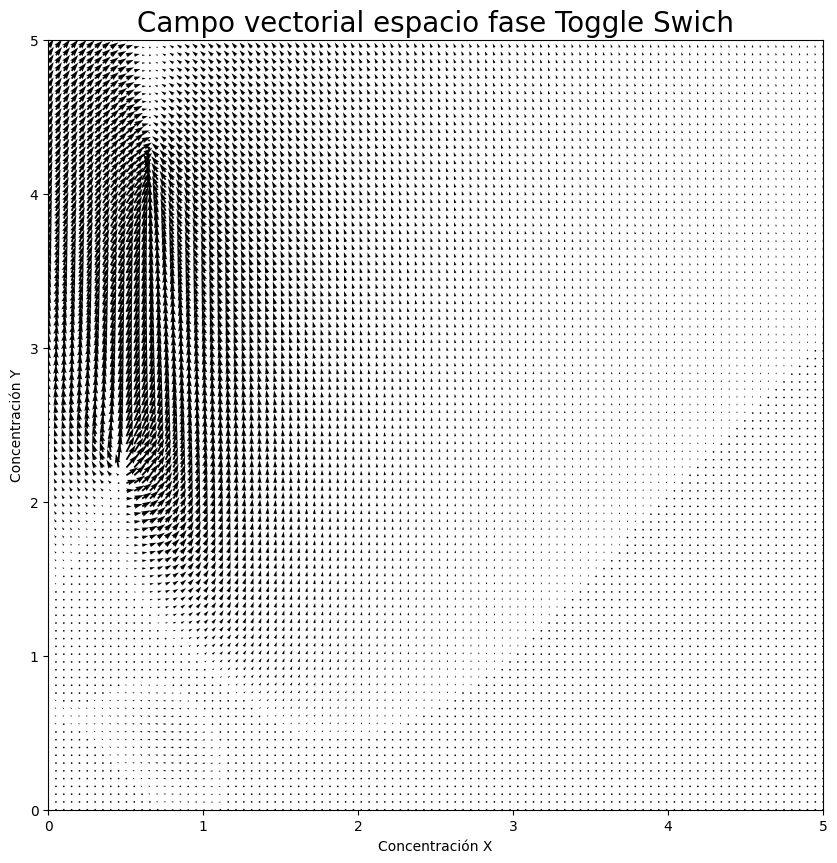

In [76]:
x_range_neg = 0
x_range_pos = 5
y_range_neg = 0
y_range_pos =5
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y12, Y22, campvecx, campvecy, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')